In [7]:
import keras
from keras.datasets import cifar10
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns

# CIFAR-10 Dataset

In [21]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

train_size = x_train.shape[0]
test_size = x_test.shape[0]
print(f'Train size = {train_size}')
print(f'Test size = {test_size}')

print('')

input_dimensions = x_train.shape[1:]
output_dimensions = y_train.shape[1:]
print(f'Input dimensions = {input_dimensions}') 
print(f'Output dimensions = {output_dimensions}')

print('')

# Output labels defined at https://www.cs.toronto.edu/~kriz/cifar.html
output_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog', 
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
print(f'Output labels = {output_labels}')

Train size = 50000
Test size = 10000

Input dimensions = (32, 32, 3)
Output dimensions = (1,)

Output labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# Data Distribution

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


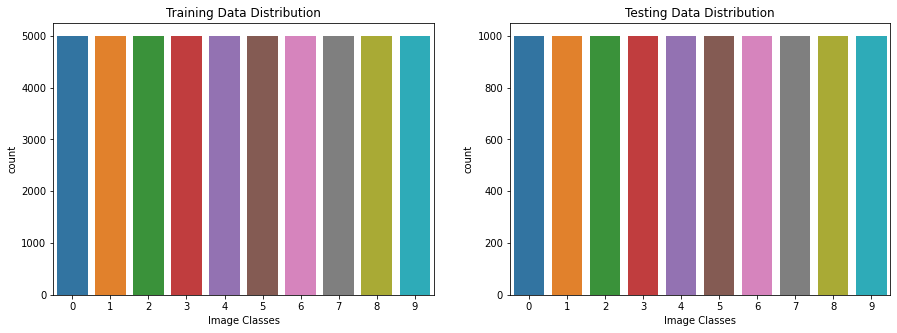

In [22]:
_, axes = plt.subplots(1,2,figsize=(15,5)) 

sns.countplot(y_train.ravel(), ax=axes[0])
axes[0].set_title('Training Data Distribution')
axes[0].set_xlabel('Image Classes')

# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axes[1])
axes[1].set_title('Testing Data Distribution')
axes[1].set_xlabel('Image Classes')
plt.show()